In [10]:
import pandas as pd
import geopandas as gpd
import numpy as np 
import os 
import matplotlib.pyplot as plt
import seaborn as sns     

In [11]:
# Sample connection
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Cleaning connection")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

# Preparing weather data

In [19]:
# Looking at the weather data and keeping columns with data
df = pd.read_csv('../data/laguardia.csv')
df.rename(str.lower, axis='columns', inplace=True)
df = df[df.report_type.isin(['FM-12', 'FM-15', 'FM-16'])]
df.drop('report_type', axis=1, inplace=True)
df.head()

/tmp/ipykernel_223/3092311829.py:2: DtypeWarning: Columns (44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/laguardia.csv')


,station,date,source,latitude,longitude,elevation,name,call_sign,quality_control,wnd,...,oc1,od1,oe1,oe2,oe3,rh1,rh2,rh3,rem,eqd
0,72503014732,2019-01-01T00:00:00,4,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",99999,V020,"130,1,N,0041,1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SYN09872503 11358 81308 10067 20050 30189 4020...,NaN
1,72503014732,2019-01-01T00:49:00,6,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",KLGA,V030,"140,5,N,0067,5",...,"0103,5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET13312/31/18 19:49:03 SPECI KLGA 010049Z 140...,NaN
2,72503014732,2019-01-01T00:51:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",KLGA,V030,"130,5,N,0067,5",...,"0103,5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET13912/31/18 19:51:01 METAR KLGA 010051Z 130...,NaN
3,72503014732,2019-01-01T01:15:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",KLGA,V030,"140,5,N,0046,5",...,"0088,5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET11212/31/18 20:15:01 SPECI KLGA 010115Z 140...,NaN
4,72503014732,2019-01-01T01:25:00,7,40.77944,-73.88035,3.4,"LAGUARDIA AIRPORT, NY US",KLGA,V030,"130,5,N,0051,5",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET11912/31/18 20:25:01 SPECI KLGA 010125Z 130...,NaN


In [20]:
# keeping potentially relevant columns
df = df[['date', 'wnd', 'vis', 'tmp', 'dew', 'slp', 'ga1',]]

# loosely transcribed meaning of columns:

# wnd = wind angle clockwise,  quality code, wind obs type, WIND-OBSERVATION speed rate (x10), quality # 9999 missing

# vis = visibility distance, quality, variability, obs qual  # 999999=missing

# tmp = temp (x10), #+9999=missing
# dew = dewpoint(x10), #+9999=missing [dew point temperature The temperature to which a given parcel of air must be cooled at constant pressure and water vapor content in order for saturation to occur

# slp = atm pressure (x10), # 99999 = missing           [seal level pressure]
# ga1 = cloud cover (scale 0-8, 9&10=obstructed), quality, base height, quality, cloud type, quality


# Maybe interesting columns:
# mw1 = weather name, quality
# oc1 = kui suured tuulepuhangud on (x10), quality

# df.drop(['source', 'station', 'latitude', 'longitude', 'name', 'elevation', 'call_sign', 'quality_control', 'cig', 'aa1', 'aa2', 'aa3', 'ab1', 'ad1', 'ae1', 'ah1', 'ah2', 'ah3', 'ah4', 'ah5', 'ah6', 'ai1', 'ai2', 'ai3', 'ai4', 'ai5', 'ai6', 'aj1', 'ak1', 'al1', 'am1', 'an1', 'at1', 'at2', 'at3', 'at4', 'at5', 'at6', 'at7', 'at8', 'au1', 'au2', 'au3', 'au4', 'aw1', 'aw2', 'aw3', 'aw4', 'aw5','ax1', 'ax2', 'ax3', 'ax4', 'ed1', 'ga2', 'ga3', 'gd1', 'gd2', 'gd3', 'gd4', 'ge1', 'gf1', 'ka1', 'ka2', 'kb1','kb2','kb3','kc1','kc2','kd1','kd2','ke1','kg1','kg2','ma1','md1', 'mf1','mg1','mh1','mk1','mv1','mw1','mw2','mw3','oc1','od1','oe1','oe2','oe3','rh1','rh2','rh3','rem','eqd'], axis=1)
df

,date,wnd,vis,tmp,dew,slp,ga1
0,2019-01-01T00:00:00,"130,1,N,0041,1","008000,1,9,9","+0067,1","+0050,1","10201,1","99,9,+00250,1,99,9"
1,2019-01-01T00:49:00,"140,5,N,0067,5","003219,5,N,5","+0070,5","+0050,5","99999,9","07,5,+00244,5,99,9"
2,2019-01-01T00:51:00,"130,5,N,0067,5","003219,5,N,5","+0067,5","+0050,5","10181,5","07,5,+00244,5,99,9"
3,2019-01-01T01:15:00,"140,5,N,0046,5","011265,5,N,5","+0072,5","+0056,5","99999,9","07,5,+00244,5,99,9"
4,2019-01-01T01:25:00,"130,5,N,0051,5","002414,5,N,5","+0072,5","+0056,5","99999,9","07,5,+00244,5,99,9"
...,...,...,...,...,...,...,...
14076,2019-12-31T20:51:00,"240,5,N,0046,5","016093,5,N,5","+0072,5","+0011,5","10028,5","04,5,+01036,5,99,9"
14077,2019-12-31T21:00:00,"240,1,N,0046,1","016000,1,9,9","+0072,1","+0011,1","10028,1","99,9,+01250,1,99,9"
14078,2019-12-31T21:51:00,"250,5,N,0062,5","016093,5,N,5","+0072,5","+0000,5","10033,5","02,5,+00914,5,99,9"
14079,2019-12-31T22:51:00,"240,5,N,0046,5","016093,5,N,5","+0072,5","+0006,5","10036,5","07,5,+00914,5,99,9"


In [21]:
# spliting out the relevant information
df['date'] = df['date'] = pd.to_datetime(df['date'])
df['wnd'] = df['wnd'].str.split(',', expand=True)[3].astype(np.uint32)      # unit: m/s, scaling factor:10,     missing: 9999
df['vis'] = df['vis'].str.split(',', expand=True)[0].astype(np.uint32)      # unit: m,                          
df['tmp'] = df['tmp'].str.split(',', expand=True)[0].astype(np.int32)       # unit: C, scaling factor:10,       missing: 9999
df['dew'] = df['dew'].str.split(',', expand=True)[0].astype(np.int32)       # unit: C, scaling factor:10,       missing: 9999
df['atm'] = df['slp'].str.split(',', expand=True)[0].astype(np.uint32)      # unit: hP, scaling factor:10,      missing: 99999
df['ga1'].fillna('99,x', inplace=True)
df['cc'] = df['ga1'].str.split(',', expand=True)[0].astype(np.uint32).astype('category') # cloud coverage: unit: okta (0 clear -> 8 covered), 99 missing
df.drop(['slp', 'ga1'], axis=1, inplace=True)

In [22]:
df[df.isnull().any(axis=1)] # no NaN left

,date,wnd,vis,tmp,dew,atm,cc


In [23]:
print(df.dtypes)
df.describe()

date    datetime64[ns]
wnd             uint32
vis             uint32
tmp              int32
dew              int32
atm             uint32
cc            category
dtype: object


,wnd,vis,tmp,dew,atm
count,13691.000000,13691.000000,13691.000000,13691.000000,13691.000000
mean,49.218538,14097.872982,134.312979,62.898693,23881.401505
std,88.596347,9506.640887,176.095325,247.540883,32309.299094
min,0.000000,0.000000,-156.000000,-272.000000,9858.000000
25%,31.000000,16000.000000,50.000000,-17.000000,10125.000000
50%,46.000000,16093.000000,133.000000,72.000000,10186.000000
75%,62.000000,16093.000000,217.000000,144.000000,10264.000000
max,9999.000000,999999.000000,9999.000000,9999.000000,99999.000000


In [24]:
print(df.shape)
df = df[(df['wnd'] != 9999)]
df = df[(df['vis'] != 999999)]
df = df[(df['tmp'] != 9999)] 
df = df[(df['dew'] != 9999)] 
df = df[(df['atm'] != 99999)]
print(df.shape)

(13691, 7)
(11598, 7)


In [ ]:
df.describe()

,wnd,vis,tmp,dew,atm
count,11598.000000,11598.000000,11598.000000,11598.000000,11598.000000
mean,48.211847,14861.065097,133.691499,50.988533,10168.289446
std,24.796421,3461.115500,100.612244,106.230097,81.400765
min,0.000000,0.000000,-156.000000,-272.000000,9858.000000
25%,31.000000,16000.000000,50.000000,-33.000000,10114.000000
50%,46.000000,16093.000000,133.000000,61.000000,10166.000000
75%,62.000000,16093.000000,222.000000,139.000000,10225.000000
max,175.000000,16093.000000,372.000000,239.000000,10408.000000


In [ ]:
day_count = 0

for group,df_group in df.groupby(df['date'].dt.date):
    day_count += 1
    h_count = 0
    for h, h_group in df_group.groupby(df_group['date'].dt.hour):
        h_count += 1
    if h_count != 24:
        print(f"Problem on date {group}, missing {24-h_count}")
if day_count != (df['date'].iloc[-1] - df['date'].iloc[0]).days:
    print("Some days are missing from dataset")


Problem on date 2019-02-08, missing 1
Problem on date 2019-03-01, missing 1
Problem on date 2019-03-04, missing 10
Problem on date 2019-03-13, missing 1
Problem on date 2019-03-16, missing 2
Problem on date 2019-05-10, missing 1
Problem on date 2019-05-31, missing 1
Problem on date 2019-09-20, missing 5
Problem on date 2019-09-21, missing 16
Problem on date 2019-09-27, missing 2
Problem on date 2019-10-02, missing 1
Problem on date 2019-10-25, missing 1
Problem on date 2019-11-22, missing 1
Some days are missing from dataset


In [ ]:
df.to_csv('../data/curated/laguardia.csv')
# TODO missing values like 9999.. should be accounted for better than just removing rn

In [ ]:
df['rh3'].value_counts()
#df[df.al1.notna()].drop(['source', 'station', 'latitude', 'longitude', 'name', 'elevation', 'call_sign', 'quality_control', 'cig', 'aa1', 'aa2', 'aa3', 'ab1', 'ad1', 'ae1', 'ah1','ah2', 'ah3','ah4','ah5','ah6', 'ai1','ai2', 'ai3','ai4','ai5','ai6'] , axis=1)


Series([], Name: rh3, dtype: int64)

In [ ]:
df.describe()

,wnd,vis,tmp,dew,atm
count,11598.000000,11598.000000,11598.000000,11598.000000,11598.000000
mean,48.211847,14861.065097,133.691499,50.988533,10168.289446
std,24.796421,3461.115500,100.612244,106.230097,81.400765
min,0.000000,0.000000,-156.000000,-272.000000,9858.000000
25%,31.000000,16000.000000,50.000000,-33.000000,10114.000000
50%,46.000000,16093.000000,133.000000,61.000000,10166.000000
75%,62.000000,16093.000000,222.000000,139.000000,10225.000000
max,175.000000,16093.000000,372.000000,239.000000,10408.000000


In [1]:
%load_ext autoreload

In [1]:
import sys
sys.path.append('../scripts/')
import weather_cleaning

In [2]:
%run ../scripts/weather_cleaning

/home/toomas/ADS/mast30034-project-1-ToomasRo/notebooks


In [4]:
weather_cleaning.clean(range(2017, 2020))
weather_cleaning.combine()

2017


/home/toomas/ADS/mast30034-project-1-ToomasRo/notebooks/../scripts/weather_cleaning.py:15: DtypeWarning: Columns (43,44,48,53,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../data/raw/weather/{year}_weather.csv')


2018


/home/toomas/ADS/mast30034-project-1-ToomasRo/notebooks/../scripts/weather_cleaning.py:15: DtypeWarning: Columns (44,45,58,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../data/raw/weather/{year}_weather.csv')


2019


/home/toomas/ADS/mast30034-project-1-ToomasRo/notebooks/../scripts/weather_cleaning.py:15: DtypeWarning: Columns (44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../data/raw/weather/{year}_weather.csv')


                wnd           vis           tmp           dew           atm  \
count  34859.000000  34859.000000  34859.000000  34859.000000  34859.000000   
mean      48.524829  14889.395221    137.383918     57.570498  10169.466192   
std       24.795912   3469.048293     99.989353    106.765513     81.299974   
min        0.000000      0.000000   -156.000000   -272.000000   9789.000000   
25%       31.000000  16000.000000     56.000000    -22.000000  10119.000000   
50%       46.000000  16093.000000    139.000000     67.000000  10168.000000   
75%       62.000000  16093.000000    222.000000    150.000000  10221.000000   
max      185.000000  16093.000000    378.000000    250.000000  10443.000000   

                 cc  
count  34859.000000  
mean      28.026736  
std       41.370429  
min        0.000000  
25%        2.000000  
50%        4.000000  
75%       99.000000  
max       99.000000  


# Taxi data cleaning


In [3]:
from pyspark.sql.types import IntegerType, DoubleType, TimestampType
from pyspark.sql import functions as F

## Merging dataframes and removing conflicts
If there is a need to change the range on which analysis is performed, the first file that is read on both cases should be updated. Works best if files naming scheme makes them sorted chronologically

In [7]:
# FHV data, not working yet

# sdf_fhv = spark.read.parquet('../data/raw/fhv/')
# #problematic = ['congestion_surcharge', 'passenger_count', 'ratecodeID']

# #sdf_fhv = sdf_fhv.drop('ratecodeID', 'passenger_count', 'ehail_fee', 'payment_type', 'congestion_surcharge', 'trip_type')   
# new = sdf_fhv.withColumn("PUlocationID",F.col("PUlocationID").cast(DoubleType()))

# #new.limit(5)
# new.dtypes
# new.printSchema()
# new.limit(5)

In [11]:
# preliminary df re-formating to combine easier with green
for file in os.listdir('../data/raw/yellow/'):
    print(file)
    sdf = spark.read.parquet('../data/raw/yellow/'+file)
    sdf = sdf.withColumn('passenger_count', sdf['passenger_count'].cast(IntegerType())) \
        .withColumn('congestion_surcharge', sdf['congestion_surcharge'].cast(IntegerType())) \
        .withColumn('ratecodeID', sdf['ratecodeID'].cast(IntegerType())) \
        .withColumnRenamed('tpep_pickup_datetime','pickup_datetime') \
        .withColumnRenamed('tpep_dropoff_datetime','dropoff_datetime') \
        .drop('airport_fee')    
    sdf.write.mode('overwrite').parquet('../data/temp/yellow/'+file)
    # congestion_surcharge: int->double, 
    # passenger_count long->double, 
    # ratecodeID long->double

2019_06.parquet


2017_06.parquet


2018_07.parquet


2017_07.parquet


2018_06.parquet


2019_08.parquet


2019_07.parquet


2017_08.parquet


2018_08.parquet


In [12]:
# preliminary df re-formating to combine easier with yellow

for file in os.listdir('../data/raw/green/'):
    print(file)
    sdf = spark.read.parquet('../data/raw/green/'+file)
    sdf = sdf.withColumn('passenger_count', sdf['passenger_count'].cast(IntegerType())) \
        .withColumn('ratecodeID', sdf['ratecodeID'].cast(IntegerType())) \
        .withColumnRenamed('lpep_pickup_datetime', 'pickup_datetime') \
        .withColumnRenamed('lpep_dropoff_datetime', 'dropoff_datetime') \
        .drop('ehail_fee', 'trip_type')

    sdf.write.mode('overwrite').parquet('../data/temp/green/'+file)


2019_06.parquet


2017_06.parquet


2018_07.parquet


2017_07.parquet


2018_06.parquet


2019_08.parquet


2019_07.parquet


2017_08.parquet


2018_08.parquet


In [13]:
sdf_yellow = spark.read.parquet('../data/temp/yellow/2017_06.parquet')

for file in sorted(os.listdir('../data/temp/yellow/'))[1:]:
    temp_df = spark.read.parquet('../data/temp/yellow/'+file)
    sdf_yellow = sdf_yellow.unionByName(temp_df)

# #problematic = ['congestion_surcharge', 'passenger_count', 'ratecodeID']
# df1 = spark.read.parquet('../data/curated/yellow/2019_08.parquet')
# df2 = spark.read.parquet('../data/curated/yellow/2017_06.parquet')

# sdf_yellow = df1.unionByName(df2)

sdf_yellow.limit(5)
print(sdf_yellow.count())
#merged_df.printSchema()

70443818


In [14]:
sdf_green = spark.read.parquet('../data/temp/green/2017_06.parquet')

for file in sorted(os.listdir('../data/temp/green/'))[1:]:
    temp_df = spark.read.parquet('../data/temp/green/'+file)
    sdf_green = sdf_green.unionByName(temp_df)

# #problematic = ['congestion_surcharge', 'passenger_count', 'ratecodeID']
# df1 = spark.read.parquet('../data/curated/yellow/2019_08.parquet')
# df2 = spark.read.parquet('../data/curated/yellow/2017_06.parquet')

# sdf_yellow = df1.unionByName(df2)

sdf_green.limit(5)
print(sdf_green.count())
#merged_df.printSchema()

6284068


In [15]:
# combine both green and yellow
sdf = sdf_yellow.unionByName(sdf_green)
sdf = sdf.withColumn('PUWeekday', (F.dayofweek(F.col('pickup_datetime')))) \
        .withColumn('PUHour', F.hour(F.col('pickup_datetime')))
sdf.limit(5)


VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,ratecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,PUWeekday,PUHour
1,2017-06-01 00:02:36,2017-06-01 00:10:02,1,1.8,1,N,161,263,1.0,8.0,0.5,0.5,1.85,0.0,0.3,11.15,null,5,0
1,2017-06-01 00:14:14,2017-06-01 00:16:50,1,0.8,1,N,237,237,1.0,4.5,0.5,0.5,0.75,0.0,0.3,6.55,null,5,0
1,2017-06-01 00:47:11,2017-06-01 00:57:47,1,1.7,1,N,48,233,1.0,8.5,0.5,0.5,1.0,0.0,0.3,10.8,null,5,0
1,2017-06-01 00:14:38,2017-06-01 00:19:49,1,1.1,1,N,246,249,1.0,5.5,0.5,0.5,1.5,0.0,0.3,8.3,null,5,0
1,2017-06-01 00:03:41,2017-06-01 00:57:09,1,14.8,1,N,166,61,2.0,48.5,0.5,0.5,0.0,0.0,0.3,49.8,null,5,0


In [16]:
#sdf = sdf.drop('congestion_surcharge')
sdf.write.mode('overwrite').parquet('../data/temp/both/raw_data.parquet')

## Exploring raw data

In [ ]:
#sdf.select().summary()

sdf.select(F.col('passenger_count'),
           F.col('trip_distance'),
           F.col('total_amount'),
           ((F.col('dropoff_datetime').cast('long')-F.col('pickup_datetime').cast('long'))/60).alias('trip_duration')).summary()


summary,passenger_count,trip_distance,total_amount,trip_duration
count,76490436,76727886,76727886,76727886
mean,1.5844927854771282,3.046011726557894,17.29796580406473,17.43078280083484
stddev,1.2321364442743832,6.99527997338513,187.24483134447192,1699.8001975945674
min,0,0.0,-1871.8,-1.05191844333333...
25%,1,1.0,9.3,6.633333333333334
50%,1,1.7,12.8,11.183333333333334
75%,2,3.2,18.96,18.45
max,9,45977.22,907071.04,36501.183333333334


In [ ]:
print(sdf.select(F.min(F.col("PULocationID"))).limit(1).collect()[0])
print(sdf.select(F.min(F.col("DOLocationID"))).limit(1).collect()[0])
print(sdf.select(F.max(F.col("PULocationID"))).limit(1).collect()[0])
print(sdf.select(F.max(F.col("DOLocationID"))).limit(1).collect()[0])
# ZoneID has to be in [1-263]


Row(min(PULocationID)=1)
Row(min(DOLocationID)=1)
Row(max(PULocationID)=265)
Row(max(DOLocationID)=265)


Text(0.5, 0, 'Weekday')

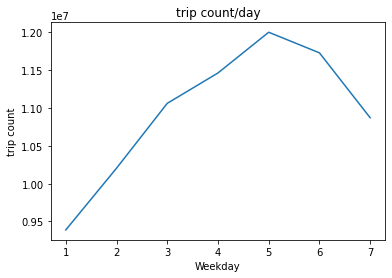

In [ ]:
# plot of trip_count per day of week
count_by_day = sdf.select(F.col('PUWeekday')).groupby('PUWeekday').count().sort(F.asc("PUWeekday")).toPandas()
plt.plot(count_by_day['PUWeekday'], count_by_day['count'])
plt.title("trip count/day")
plt.ylabel("trip count")
plt.xlabel("Weekday")

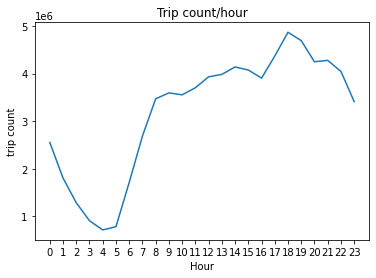

In [ ]:
# plot of trip_count per hour of day
count_by_hour = sdf.select(F.col('PUHour')).groupby('PUHour').count().sort(F.asc("PUHour")).toPandas()
plt.plot(count_by_hour['PUHour'], count_by_hour['count'])
plt.title("Trip count/hour")
plt.xticks(np.arange(0, 24))
plt.ylabel("trip count")
plt.xlabel("Hour")
plt.show()

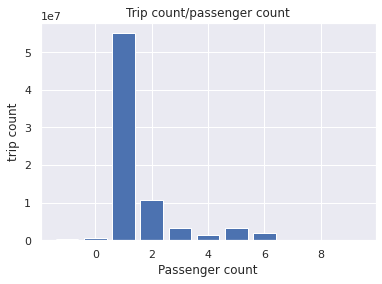

In [ ]:
# plot of n of trips against passegner count
passenger_count = sdf.select(F.col('passenger_count')).groupby('passenger_count').count().sort(F.asc("passenger_count")).toPandas()
passenger_count.iat[0, 0] = -1  # quick way to deal with NaN
plt.bar(passenger_count['passenger_count'],passenger_count['count'])
plt.title("Trip count/passenger count")
plt.ylabel("trip count")
plt.xlabel("Passenger count")
plt.show()

<BarContainer object of 11 artists>

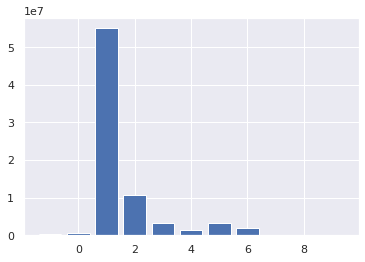

In [ ]:
plt.bar(passenger_count['passenger_count'],passenger_count['count'])

In [ ]:
df = sdf.sample(False, 0.005, 42).toPandas()

In [ ]:
df.shape

(384635, 20)

<AxesSubplot:xlabel='trip_distance'>

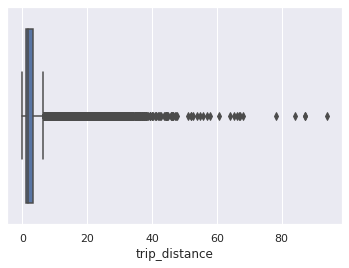

In [ ]:
# Really unbalaned
sns.boxplot(x=df['trip_distance'])

<AxesSubplot:>

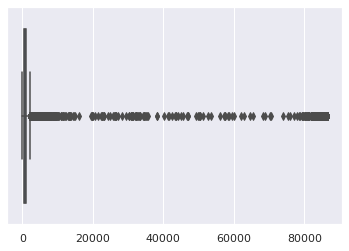

In [ ]:
sns.boxplot(x=(df['dropoff_datetime']-df['pickup_datetime'])/np.timedelta64(1, 's'))

<AxesSubplot:xlabel='PUDayofweek', ylabel='trip_distance'>

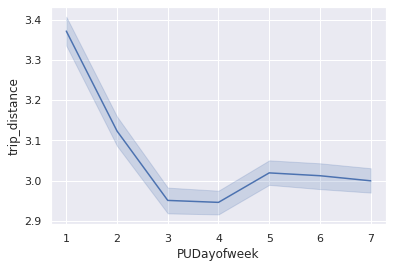

In [ ]:
sns.lineplot(x='PUWeekday', y='trip_distance',data=df)

<AxesSubplot:xlabel='PUHour', ylabel='trip_distance'>

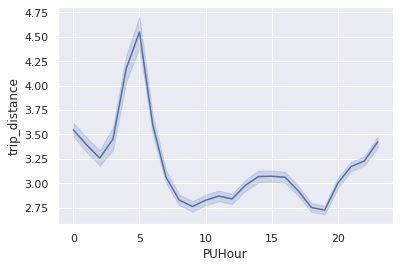

In [ ]:
sns.lineplot(x='PUHour', y='trip_distance',data=df)

In [ ]:
sdf.select(F.col('PUHour'), F.col('trip_distance')).groupby('PUHour').avg()

PUHour,avg(PUHour),avg(trip_distance)
12,12.0,2.832958444373077
22,22.0,3.2414123835953395
1,1.0,3.410588547233864
13,13.0,2.957946121943969
6,6.0,3.582207328988525
16,16.0,3.0827843588484094
3,3.0,3.423220048652608
20,20.0,3.012102861766894
5,5.0,4.557649421958659
19,19.0,2.745293196482568


In [72]:
asi = sdf.select(F.col('PUHour'), F.col('PUWeekday'), F.col('trip_distance')).groupby('PUHour', 'PUWeekday').avg().toPandas()

In [107]:
asi = asi[['PUHour', 'PUWeekday', 'avg(trip_distance)']]
temp = []
for hour in range(0, 24):
    temp2 = []
    for day in range(1, 8):
        temp2.append(asi[(asi['PUHour'] == hour) & (
            asi['PUWeekday'] == day)]['avg(trip_distance)'].iloc[0])
    temp.append(temp2)

temp3 = pd.DataFrame(temp, columns=[x for x in range(1, 8)])

[]

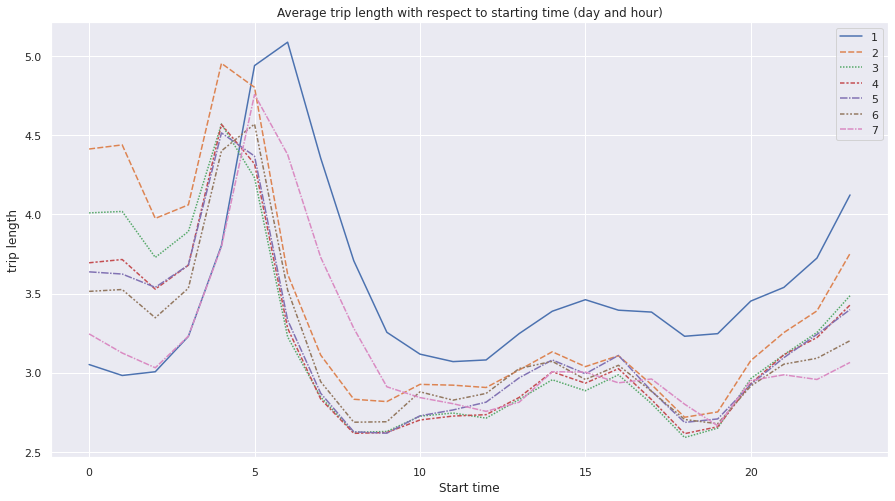

In [108]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=temp3)
plt.title("Average trip length with respect to starting time (day and hour)")
plt.ylabel("trip length")
plt.xlabel("Start time")

plt.plot()

<AxesSubplot:xlabel='PUDayofweek', ylabel='trip_distance'>

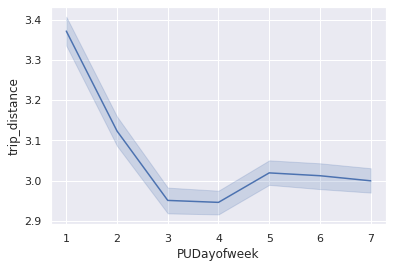

In [ ]:
sns.lineplot(x='PUWeekday', y='trip_distance',data=df)

<AxesSubplot:xlabel='trip_distance', ylabel='Frequency'>

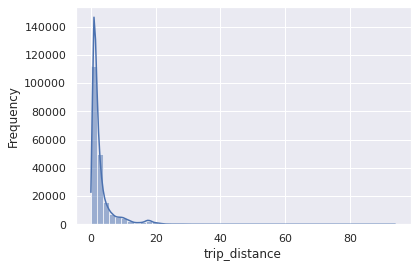

In [ ]:
sns.histplot(data=df,
             x="trip_distance",
             stat="frequency",    # normalize the histogram so that the total area of bars is 1
             kde=True,          # plot kernel density estimate
             bins=50            # number of bins of the histogram
            )

In [ ]:
sdf.limit(5)

VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,ratecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,PUDayofweek,PUHour
1,2017-06-01 00:02:36,2017-06-01 00:10:02,1,1.8,1,N,161,263,1.0,8.0,0.5,0.5,1.85,0.0,0.3,11.15,null,5,0
1,2017-06-01 00:14:14,2017-06-01 00:16:50,1,0.8,1,N,237,237,1.0,4.5,0.5,0.5,0.75,0.0,0.3,6.55,null,5,0
1,2017-06-01 00:47:11,2017-06-01 00:57:47,1,1.7,1,N,48,233,1.0,8.5,0.5,0.5,1.0,0.0,0.3,10.8,null,5,0
1,2017-06-01 00:14:38,2017-06-01 00:19:49,1,1.1,1,N,246,249,1.0,5.5,0.5,0.5,1.5,0.0,0.3,8.3,null,5,0
1,2017-06-01 00:03:41,2017-06-01 00:57:09,1,14.8,1,N,166,61,2.0,48.5,0.5,0.5,0.0,0.0,0.3,49.8,null,5,0


## Filtering out outliers and keeping important variables

In [12]:
sdf = spark.read.parquet('../data/temp/both/raw_data.parquet')

In [13]:
sdf.limit(1)

VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,ratecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,PUWeekday,PUHour
1,2018-06-01 00:15:40,2018-06-01 00:16:46,1,0.0,1,N,145,145,2.0,3.0,0.5,0.5,0.0,0.0,0.3,4.3,null,6,0


In [14]:
trip_dist_upper = 150   # TODO make it 2-3std
total_amount_lower = 1000
trip_duration_uper = 5*60


def modify_sdf(sdf):
    return sdf \
        .drop('VendorID', 'ratecodeID', 'store_and_fwd_flag', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge') \
        .dropna(how='any') \
        .filter((F.month('pickup_datetime') >= 6) & (F.month('dropoff_datetime') <= 8) == True) \
        .filter((F.year('pickup_datetime').isin([2017, 2018, 2019])) & (F.year('dropoff_datetime').isin([2017, 2018, 2019]))) \
        .filter(F.col('passenger_count') > 0) \
        .filter((F.col('trip_distance') > 0) & (F.col('trip_distance') < trip_dist_upper)) \
        .filter((F.col('PULocationID') < 264) & (F.col('DOLocationID') < 264)) \
        .filter((F.col('total_amount') > 0) & (F.col('total_amount') < total_amount_lower)) \
        .withColumn('trip_duration', (F.col('dropoff_datetime').cast('long')-F.col('pickup_datetime').cast('long'))/60) \
        .filter((F.col('trip_duration') > 0) & (F.col('trip_duration') < trip_duration_uper)) \
        .withColumn('PUMonth', F.month(F.col('pickup_datetime'))) \
        .withColumn('PUDay', F.dayofmonth(F.col('pickup_datetime'))) \
        .drop('pickup_datetime', 'dropoff_datetime')




print(sdf.count())
#sdf.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c)           for c in sdf.columns if not c in ['pickup_datetime', 'dropoff_datetime']]).show()
new_sdf = modify_sdf(sdf)
print(new_sdf.count())


76727886


74016294


In [11]:
new_sdf.select(F.col('passenger_count'),
           F.col('trip_distance'),
           F.col('total_amount'),
           F.col('trip_duration')).summary()

summary,passenger_count,trip_distance,total_amount,trip_duration
count,74016294,74016294,74016294,74016294
mean,1.598887023443784,3.016778951672325,16.914594572600777,14.405820661145487
stddev,1.232090439694568,3.7377244973172563,13.451536656736094,11.667944045012398
min,1,0.01,0.01,0.016666666666666666
25%,1,1.0,9.3,6.7
50%,1,1.7,12.8,11.183333333333334
75%,2,3.19,18.8,18.3
max,9,145.01,989.8,299.96666666666664


In [15]:
new_sdf.write.mode('overwrite').parquet('../data/temp/both_bit_cleaned/bit_cleaned_data.parquet')

# New Thing

In [17]:
sdf = spark.read.parquet('../data/temp/both_bit_cleaned/bit_cleaned_data.parquet')

In [18]:
sdf.limit(5)

passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,PUWeekday,PUHour,trip_duration,PUMonth,PUDay
1,1.2,249,90,8.15,7,0,4.416666666666667,7,1
2,0.2,249,158,4.3,7,0,1.5666666666666667,7,1
1,4.3,100,45,20.15,7,0,15.316666666666666,7,1
1,8.3,138,162,40.86,7,0,23.95,7,1
1,1.9,107,158,11.8,7,0,15.016666666666667,7,1


In [145]:
def filter_yellow(sdf):

    return sdf \
            .drop('VendorID', 'store_and_fwd_flag', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'congestion_surcharge', 'improvement_surcharge','airport_fee') \
            .filter((F.col('trip_distance') > 0) & (F.col('trip_distance') < 150)) \
            .withColumn('PUWeekday', (F.dayofweek(F.col('tpep_pickup_datetime')))) \
            .withColumn('PUHour', F.hour(F.col('tpep_pickup_datetime'))) \
            .filter(F.col('passenger_count') > 0)

def filter_green(sdf):
    return sdf \
        .drop('VendorID', 'store_and_fwd_flag', 'payment_type', 'fate_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'congestion_surcharge', 'improvement_surcharge','airport_fee') \
        .filter((F.col('trip_distance') > 0) & (F.col('trip_distance') < 150)) \
        .withColumn('PUWeekday', (F.dayofweek(F.col('lpep_pickup_datetime')))) \
        .withColumn('PUHour', F.hour(F.col('lpep_pickup_datetime'))) 

print(sdf_yellow.count())
sdf_new_yellow = filter_yellow(sdf_yellow)
print(sdf_new_yellow.count())
#sdf_new_green = filter_green(sdf_green)
sdf_new_yellow.tail(5)


Py4JJavaError: An error occurred while calling o1914.count.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:748)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:120)
	at org.apache.spark.SparkContext.defaultParallelism(SparkContext.scala:2524)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.$anonfun$apply$1(CoalesceShufflePartitions.scala:60)
	at scala.runtime.java8.JFunction0$mcI$sp.apply(JFunction0$mcI$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.apply(CoalesceShufflePartitions.scala:57)
	at org.apache.spark.sql.execution.adaptive.CoalesceShufflePartitions.apply(CoalesceShufflePartitions.scala:33)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$optimizeQueryStage$1(AdaptiveSparkPlanExec.scala:153)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.optimizeQueryStage(AdaptiveSparkPlanExec.scala:152)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.newQueryStage(AdaptiveSparkPlanExec.scala:525)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:486)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$createQueryStages$2(AdaptiveSparkPlanExec.scala:516)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:286)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.TraversableLike.map(TraversableLike.scala:286)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:279)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.createQueryStages(AdaptiveSparkPlanExec.scala:516)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$1(AdaptiveSparkPlanExec.scala:233)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.getFinalPhysicalPlan(AdaptiveSparkPlanExec.scala:228)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:367)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:340)
	at org.apache.spark.sql.Dataset.$anonfun$count$1(Dataset.scala:3161)
	at org.apache.spark.sql.Dataset.$anonfun$count$1$adapted(Dataset.scala:3160)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset.count(Dataset.scala:3160)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:
sdf_green.limit(5)

VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
2,2017-06-01 00:28:16,2017-06-01 00:35:25,N,1,65,40,1,1.75,7.5,0.5,0.5,1.76,0.0,null,0.3,10.56,1.0,1,null
1,2017-06-01 00:08:33,2017-06-01 00:19:25,N,1,116,42,2,2.1,9.5,0.5,0.5,2.15,0.0,null,0.3,12.95,1.0,1,null
2,2017-06-01 00:21:12,2017-06-01 00:27:38,N,1,112,112,1,1.24,6.5,0.5,0.5,0.0,0.0,null,0.3,7.8,2.0,1,null
2,2017-06-01 00:04:20,2017-06-01 00:24:13,N,1,255,195,2,4.94,18.0,0.5,0.5,3.86,0.0,null,0.3,23.16,1.0,1,null
2,2017-06-01 00:38:09,2017-06-01 00:53:08,N,1,25,62,1,3.13,13.0,0.5,0.5,2.86,0.0,null,0.3,17.16,1.0,1,null


In [ ]:
sdf_yellow.limit(5)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1,2017-06-01 00:02:36,2017-06-01 00:10:02,1,1.8,1,N,161,263,1,8.0,0.5,0.5,1.85,0.0,0.3,11.15,null,null
1,2017-06-01 00:14:14,2017-06-01 00:16:50,1,0.8,1,N,237,237,1,4.5,0.5,0.5,0.75,0.0,0.3,6.55,null,null
1,2017-06-01 00:47:11,2017-06-01 00:57:47,1,1.7,1,N,48,233,1,8.5,0.5,0.5,1.0,0.0,0.3,10.8,null,null
1,2017-06-01 00:14:38,2017-06-01 00:19:49,1,1.1,1,N,246,249,1,5.5,0.5,0.5,1.5,0.0,0.3,8.3,null,null
1,2017-06-01 00:03:41,2017-06-01 00:57:09,1,14.8,1,N,166,61,2,48.5,0.5,0.5,0.0,0.0,0.3,49.8,null,null
